## Run subject routine

In [1]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt

subject = 100
efcp_routine.subject_routine(subject=subject, fs_force=500, fs_emg=2148.1481, bpf=[20, 500], lpf=20, debug=0)

Processing block 1


KeyboardInterrupt: 

## Making the models

In [23]:
D = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100.csv'))
emg = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100_emg.csv'))
mov = pd.read_csv(os.path.join(ANALYSIS_PATH, f'efcp_100_mov.csv'))

### Visual inspection of the data

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_7282/1385713238.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emg_trial['e5'] = emg_trial['e5']*50


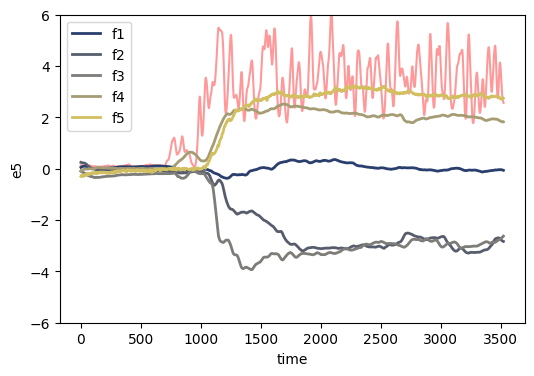

In [59]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

BN = 3
TN = 11

mov_trial = mov[(mov['BN'])==BN & (mov['TN']==TN) & (mov['state']<4)]
emg_trial = emg[(emg['BN'])==BN & (emg['TN']==TN)]

# plot force:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 4))
colors = sns.color_palette("cividis", 5)  # Generate a list of 5 colors from the 'cividis' palette

# Plot emg:
emg_trial['e5'] = emg_trial['e5']*50
sns.lineplot(data=emg_trial, x='time', y='e5', ax=ax1, color='r', alpha=0.4)

# Plot force
sns.lineplot(data=mov_trial, x='time', y='f1', ax=ax1, label='f1', color=colors[0], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f2', ax=ax1, label='f2', color=colors[1], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f3', ax=ax1, label='f3', color=colors[2], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f4', ax=ax1, label='f4', color=colors[3], lw=2)
sns.lineplot(data=mov_trial, x='time', y='f5', ax=ax1, label='f5', color=colors[4], lw=2)
ax1.set_ylim([-6, 6])
# ax1.set_ylabel('Force')
ax1.legend()

plt.show()

### Avg muscle activity patterns matrix

         sn  BN  TN  trial_correct  state        time        e1        e2  \
570936  100   3  11              1    3.0   500.42725  0.002038  0.002957   
570937  100   3  11              1    3.0   500.89264  0.002019  0.002959   
570938  100   3  11              1    3.0   501.35803  0.002003  0.002962   
570939  100   3  11              1    3.0   501.82343  0.001989  0.002964   
570940  100   3  11              1    3.0   502.28882  0.001977  0.002966   
...     ...  ..  ..            ...    ...         ...       ...       ...   
576270  100   3  11              1    3.0  2983.49760  0.003700  0.003595   
576271  100   3  11              1    3.0  2983.96300  0.003702  0.003583   
576272  100   3  11              1    3.0  2984.42850  0.003704  0.003572   
576273  100   3  11              1    3.0  2984.89380  0.003706  0.003562   
576274  100   3  11              1    3.0  2985.35910  0.003707  0.003552   

              e3        e4        e5        f1        f2        f3        f

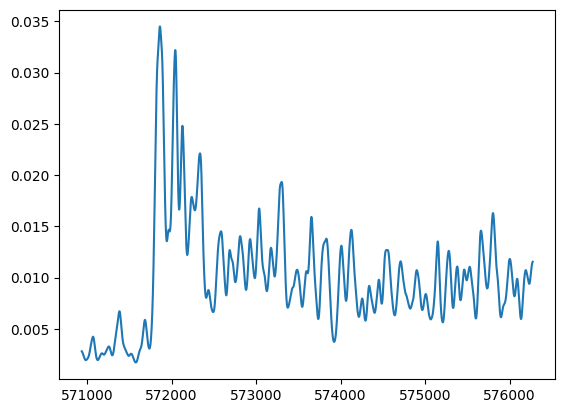

         sn  BN  TN  trial_correct  state        time        e1        e2  \
577350  100   3  12              1    3.0   500.42725  0.002456  0.001646   
577351  100   3  12              1    3.0   500.89264  0.002478  0.001659   
577352  100   3  12              1    3.0   501.35803  0.002499  0.001674   
577353  100   3  12              1    3.0   501.82343  0.002519  0.001689   
577354  100   3  12              1    3.0   502.28882  0.002538  0.001706   
...     ...  ..  ..            ...    ...         ...       ...       ...   
582345  100   3  12              1    3.0  2825.69120  0.003374  0.003405   
582346  100   3  12              1    3.0  2826.15670  0.003368  0.003417   
582347  100   3  12              1    3.0  2826.62200  0.003364  0.003430   
582348  100   3  12              1    3.0  2827.08740  0.003361  0.003442   
582349  100   3  12              1    3.0  2827.55270  0.003359  0.003455   

              e3        e4        e5        f1        f2        f3        f

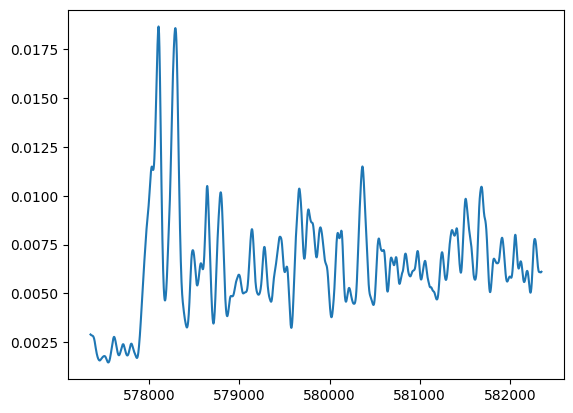

         sn  BN  TN  trial_correct  state        time        e1        e2  \
583427  100   3  13              1    3.0   500.42725  0.001938  0.002070   
583428  100   3  13              1    3.0   500.89264  0.001965  0.002053   
583429  100   3  13              1    3.0   501.35803  0.001992  0.002036   
583430  100   3  13              1    3.0   501.82343  0.002017  0.002020   
583431  100   3  13              1    3.0   502.28882  0.002042  0.002004   
...     ...  ..  ..            ...    ...         ...       ...       ...   
588405  100   3  13              1    3.0  2817.77200  0.003184  0.003551   
588406  100   3  13              1    3.0  2818.23730  0.003205  0.003546   
588407  100   3  13              1    3.0  2818.70260  0.003224  0.003542   
588408  100   3  13              1    3.0  2819.16800  0.003241  0.003539   
588409  100   3  13              1    3.0  2819.63350  0.003257  0.003536   

              e3        e4        e5        f1        f2        f3        f

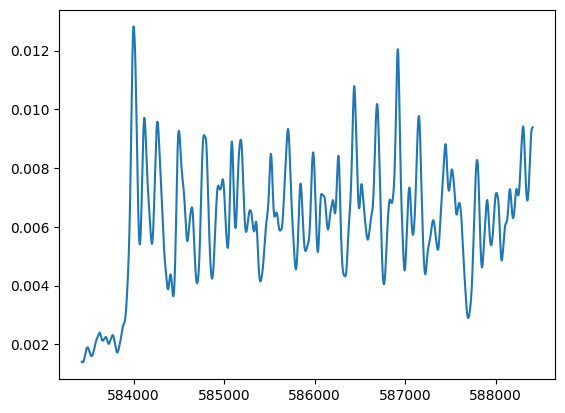

         sn  BN  TN  trial_correct  state        time        e1        e2  \
589487  100   3  14              1    3.0   500.43488  0.001857  0.001718   
589488  100   3  14              1    3.0   500.90027  0.001857  0.001708   
589489  100   3  14              1    3.0   501.36566  0.001857  0.001699   
589490  100   3  14              1    3.0   501.83105  0.001856  0.001690   
589491  100   3  14              1    3.0   502.29645  0.001855  0.001683   
...     ...  ..  ..            ...    ...         ...       ...       ...   
594667  100   3  14              1    3.0  2911.81180  0.003738  0.002972   
594668  100   3  14              1    3.0  2912.27730  0.003724  0.002979   
594669  100   3  14              1    3.0  2912.74270  0.003711  0.002985   
594670  100   3  14              1    3.0  2913.20800  0.003699  0.002989   
594671  100   3  14              1    3.0  2913.67330  0.003688  0.002992   

              e3        e4        e5        f1        f2        f3        f

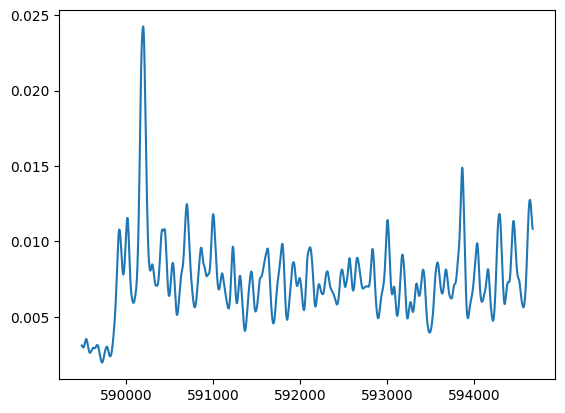

         sn  BN  TN  trial_correct  state        time        e1        e2  \
595747  100   3  15              1    3.0   500.43488  0.001298  0.001840   
595748  100   3  15              1    3.0   500.90027  0.001295  0.001833   
595749  100   3  15              1    3.0   501.36566  0.001293  0.001825   
595750  100   3  15              1    3.0   501.83105  0.001291  0.001817   
595751  100   3  15              1    3.0   502.29645  0.001289  0.001809   
...     ...  ..  ..            ...    ...         ...       ...       ...   
600707  100   3  15              1    3.0  2809.40230  0.003306  0.002824   
600708  100   3  15              1    3.0  2809.86800  0.003299  0.002829   
600709  100   3  15              1    3.0  2810.33330  0.003292  0.002832   
600710  100   3  15              1    3.0  2810.79860  0.003285  0.002835   
600711  100   3  15              1    3.0  2811.26420  0.003279  0.002838   

              e3        e4        e5        f1        f2        f3        f

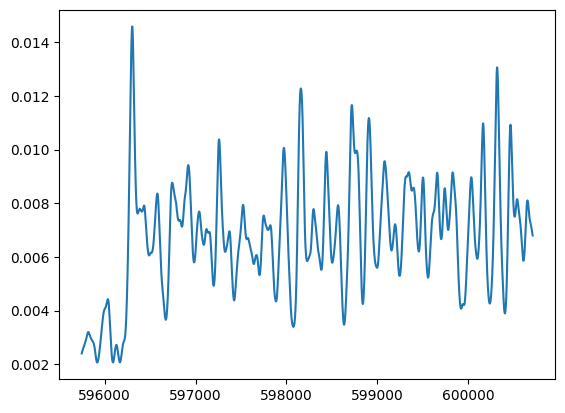

         sn  BN  TN  trial_correct  state        time        e1        e2  \
691744  100   3  26              1    3.0   500.42725  0.000859  0.002138   
691745  100   3  26              1    3.0   500.88500  0.000851  0.002157   
691746  100   3  26              1    3.0   501.35803  0.000843  0.002177   
691747  100   3  26              1    3.0   501.83105  0.000836  0.002197   
691748  100   3  26              1    3.0   502.28882  0.000829  0.002217   
...     ...  ..  ..            ...    ...         ...       ...       ...   
696930  100   3  26              1    3.0  2914.59670  0.004209  0.002101   
696931  100   3  26              1    3.0  2915.06960  0.004217  0.002090   
696932  100   3  26              1    3.0  2915.52730  0.004224  0.002081   
696933  100   3  26              1    3.0  2916.00050  0.004231  0.002072   
696934  100   3  26              1    3.0  2916.45800  0.004237  0.002065   

              e3        e4        e5        f1        f2        f3        f

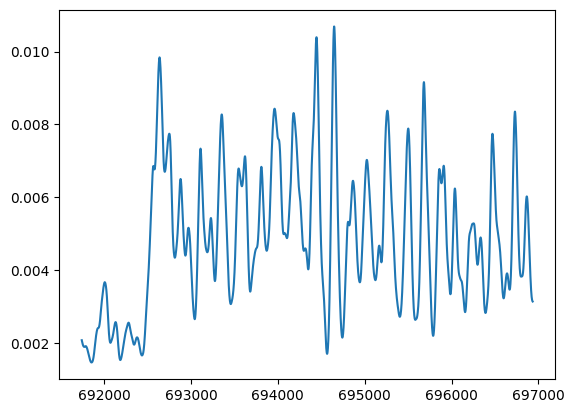

         sn  BN  TN  trial_correct  state        time        e1        e2  \
698010  100   3  27              1    3.0   500.42725  0.002089  0.002150   
698011  100   3  27              1    3.0   500.90027  0.002080  0.002154   
698012  100   3  27              1    3.0   501.35803  0.002072  0.002158   
698013  100   3  27              1    3.0   501.83105  0.002065  0.002162   
698014  100   3  27              1    3.0   502.30408  0.002059  0.002167   
...     ...  ..  ..            ...    ...         ...       ...       ...   
702894  100   3  27              1    3.0  2774.01730  0.002313  0.004090   
702895  100   3  27              1    3.0  2774.49020  0.002303  0.004103   
702896  100   3  27              1    3.0  2774.94820  0.002294  0.004114   
702897  100   3  27              1    3.0  2775.42110  0.002284  0.004125   
702898  100   3  27              1    3.0  2775.87900  0.002275  0.004134   

              e3        e4        e5        f1        f2        f3        f

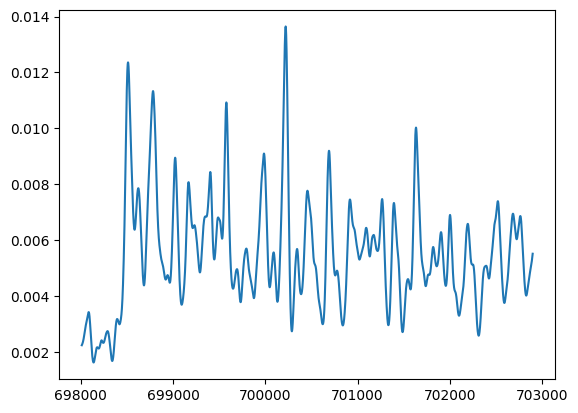

         sn  BN  TN  trial_correct  state        time        e1        e2  \
703976  100   3  28              1    3.0   500.44250  0.002455  0.002476   
703977  100   3  28              1    3.0   500.90027  0.002484  0.002464   
703978  100   3  28              1    3.0   501.37330  0.002513  0.002452   
703979  100   3  28              1    3.0   501.83105  0.002541  0.002439   
703980  100   3  28              1    3.0   502.30408  0.002568  0.002425   
...     ...  ..  ..            ...    ...         ...       ...       ...   
709586  100   3  28              1    3.0  3111.98440  0.002940  0.002242   
709587  100   3  28              1    3.0  3112.45730  0.002930  0.002235   
709588  100   3  28              1    3.0  3112.91500  0.002921  0.002230   
709589  100   3  28              1    3.0  3113.38820  0.002914  0.002224   
709590  100   3  28              1    3.0  3113.84570  0.002908  0.002219   

              e3        e4        e5        f1        f2        f3        f

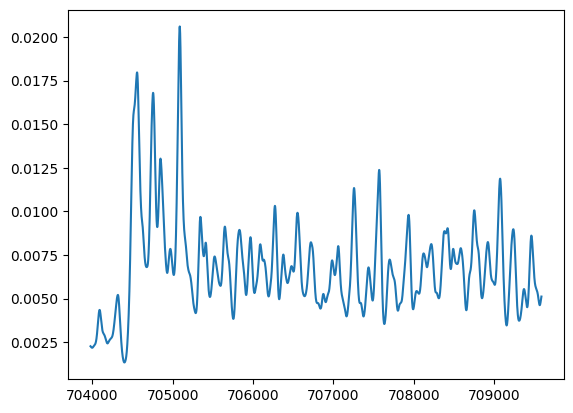

         sn  BN  TN  trial_correct  state        time        e1        e2  \
710667  100   3  29              1    3.0   500.42725  0.002853  0.001433   
710668  100   3  29              1    3.0   500.88500  0.002836  0.001417   
710669  100   3  29              1    3.0   501.35803  0.002821  0.001401   
710670  100   3  29              1    3.0   501.81580  0.002807  0.001386   
710671  100   3  29              1    3.0   502.28882  0.002795  0.001372   
...     ...  ..  ..            ...    ...         ...       ...       ...   
715602  100   3  29              1    3.0  2797.76000  0.003783  0.001863   
715603  100   3  29              1    3.0  2798.21780  0.003768  0.001863   
715604  100   3  29              1    3.0  2798.69100  0.003753  0.001861   
715605  100   3  29              1    3.0  2799.14840  0.003739  0.001860   
715606  100   3  29              1    3.0  2799.62160  0.003728  0.001858   

              e3        e4        e5        f1        f2        f3        f

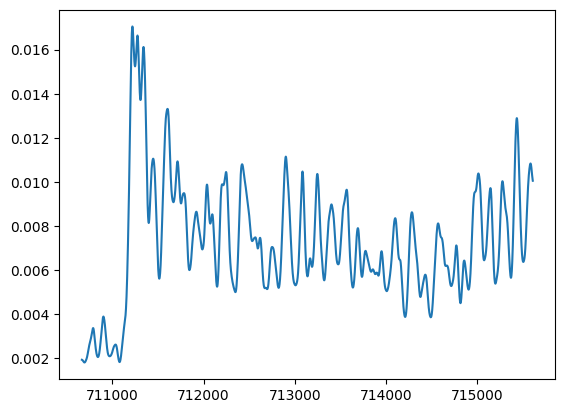

In [ ]:
# Chords ordered:
chords = np.array(['92999', '99299', '99929', '91999', '99199', '99919', 
                         '92299', '99229', '92929', '92199', '91299', '92919', '91929', '99219', '99129', '91199', '99119', '91919',
                         '92229', '92219', '91229', '92129', '92119', '91219', '91129', '91119'])
num_channels = 10
channels = ['f1', 'f2', 'f3', 'f4', 'f5', 'e1', 'e2', 'e3', 'e4', 'e5']

M = []
chordID = []
for chord in chords:
    # find the rows in D that correspond to the chord:
    rows = D[(D['chordID']==int(chord)) & (D['trial_correct']==1)]

    BN = rows['BN'].values.flatten()
    TN = rows['TN'].values.flatten()
    
    # loop on all trials:
    for i in range(len(BN)):
        # get the EMG data for the trial:
        emg_trials = emg[(emg['BN']==BN[i]) & (emg['TN']==TN[i])]
        emg_trials = emg_trials[emg_trials['state'] == 3.0]
        print(emg_trials)
        plt.plot(emg_trials['e5'])
        plt.show()
        avg_emg_pattern = emg_trials[channels].mean().to_numpy()
        M.append(avg_emg_pattern)
        chordID.append(int(chord))
M = np.vstack(M)
chordID = np.array(chordID, dtype=int).reshape(-1, 1)

df_M = pd.DataFrame(np.hstack((chordID, M)), columns=['chordID']+channels)
df_M['chordID'] = df_M['chordID'].astype(int)
df_M.to_csv(os.path.join(ANALYSIS_PATH, 'efcp_100_avgEMG.csv'), index=False)


### Heatmap

[0.01717909 0.16051293 0.1067089  0.08792974 0.02142299 0.05384021
 0.23873947 0.3489566  0.3153815  0.09198601]


[Text(0.5, 0, 'f1'),
 Text(1.5, 0, 'f2'),
 Text(2.5, 0, 'f3'),
 Text(3.5, 0, 'f4'),
 Text(4.5, 0, 'f5'),
 Text(5.5, 0, 'e1'),
 Text(6.5, 0, 'e2'),
 Text(7.5, 0, 'e3'),
 Text(8.5, 0, 'e4'),
 Text(9.5, 0, 'e5')]

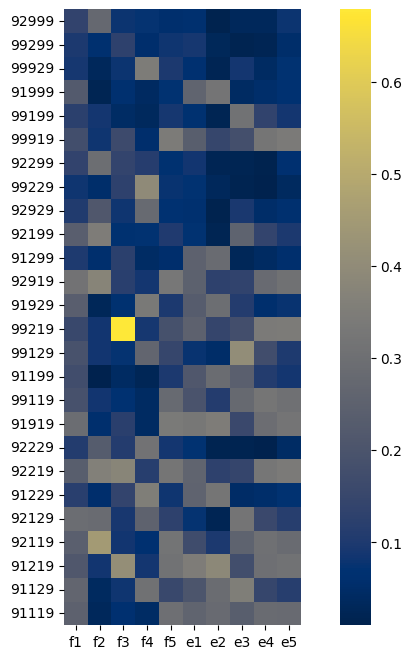

In [55]:
from utils.config import *
import pandas as pd
import numpy as np
from utils import dataset as ds
from utils import emg_handler
import efcp_routine
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

df_M = pd.read_csv(os.path.join(ANALYSIS_PATH, 'efcp_100_avgEMG.csv'))

chords = np.array(['92999', '99299', '99929', '91999', '99199', '99919', 
                         '92299', '99229', '92929', '92199', '91299', '92919', '91929', '99219', '99129', '91199', '99119', '91919',
                         '92229', '92219', '91229', '92129', '92119', '91219', '91129', '91119'])
num_channels = 10
channels = ['f1', 'f2', 'f3', 'f4', 'f5', 'e1', 'e2', 'e3', 'e4', 'e5']

chordID = df_M['chordID'].values.flatten()
M = []
for chord in chords:
    # find and average the rows of the chord:
    trials = df_M[df_M['chordID'] == int(chord)]
    avg_emg_pattern = trials[channels].mean().to_numpy()
    M.append(avg_emg_pattern)
M = np.vstack(M)
norm_channels = np.linalg.norm(M, axis=0)
print(norm_channels)
M = M / norm_channels

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(M, cmap='cividis', ax=ax, square=True)
ax.set_yticks(np.arange(len(chords))+0.5)
ax.set_yticklabels(chords, rotation=0)
ax.set_xticks(np.arange(num_channels)+0.5)
ax.set_xticklabels(channels)


In [52]:
(D['chordID']==92999).sum()

np.int64(20)